In [1]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
import tensorflow as tf
from tensorflow import keras
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.compat.v1.ConfigProto(gpu_options=tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8)#device_count={'GPU':1}
)

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector, Masking, Embedding
from keras.models import Model
from keras import regularizers
from keras.preprocessing.sequence import pad_sequences


import os
import csv
from os import listdir
os.environ["CUDA_VISIBLE_DIVICES"]=''

# set random seed
seed(10)
tf.random.set_seed(10)

In [2]:
## 사용자의 log 분석
'''
original_df = []
scaled_df = []
scaler = MinMaxScaler()

# 모든 사용자 load
users = ['0mnEB226qqgHE79KLEfxRj6fiEK2']

for user in users:
    #print(user)
    original_list = []
    scaled_list = []
    len_list = []

    # log_info/user 폴더 하위에 있는 모든 파일에 대해 (즉, 모든 log파일에 대해) 도로 세그먼트 정보를 생성
    for file in listdir('./log_segment_info/'+user):
        log_name = file.split("_")[0]

        # log{logname}_info.csv 파일을 load
        log_csv_name= './log_segment_info/'+user+"/"+file
        if('segment' not in file):
            continue
            
        #print(log_csv_name)
        if os.path.isfile(log_csv_name):
            csv = pd.read_csv(log_csv_name, usecols=['mercX', 'mercY'])
            if len(csv) == 0:
                print("log length is 0")
                continue
                
            # segment matching이 실패한 행 제외
            #csv = csv[csv['seg_id'].notnull()]
            
            # 정규화
            scaled_csv = scaler.fit_transform(csv)
            
            original_list.append(csv.values.tolist())
            scaled_list.append(scaled_csv)
            len_list.append(len(csv))
        else:
            print("no log info")

    print(len_list)
    

    # 분포 그리기
    sorted_list = sorted(len_list)
    print(sorted_list)
    
    label = np.arange(len(sorted_list))
    index = np.arange(len(sorted_list))
    plt.bar(index, sorted_list)
    plt.title('User log length', fontsize=20)
    plt.xlabel('file', fontsize=18)
    plt.ylabel('length', fontsize=18)
    plt.xticks(index, label, fontsize=15)
    plt.show()

    # 최대 길이 선택
    selected_length = 6492

    # padding 추가
    original_df = pad_sequences(original_list, padding='post', maxlen=selected_length, dtype='float64')
    scaled_df = pad_sequences(scaled_list, padding='post', maxlen=selected_length, dtype='float64')
    print(scaled_df.shape)
    print(scaled_df)
'''

'\noriginal_df = []\nscaled_df = []\nscaler = MinMaxScaler()\n\n# 모든 사용자 load\nusers = [\'0mnEB226qqgHE79KLEfxRj6fiEK2\']\n\nfor user in users:\n    #print(user)\n    original_list = []\n    scaled_list = []\n    len_list = []\n\n    # log_info/user 폴더 하위에 있는 모든 파일에 대해 (즉, 모든 log파일에 대해) 도로 세그먼트 정보를 생성\n    for file in listdir(\'./log_segment_info/\'+user):\n        log_name = file.split("_")[0]\n\n        # log{logname}_info.csv 파일을 load\n        log_csv_name= \'./log_segment_info/\'+user+"/"+file\n        if(\'segment\' not in file):\n            continue\n            \n        #print(log_csv_name)\n        if os.path.isfile(log_csv_name):\n            csv = pd.read_csv(log_csv_name, usecols=[\'mercX\', \'mercY\'])\n            if len(csv) == 0:\n                print("log length is 0")\n                continue\n                \n            # segment matching이 실패한 행 제외\n            #csv = csv[csv[\'seg_id\'].notnull()]\n            \n            # 정규화\n            scaled_csv = scale

In [2]:
## 파일 불러오기 (단일 파일용)
dir = 'C:/Users/HYS/Desktop/ratio/prev_src/log_segment_info/0mnEB226qqgHE79KLEfxRj6fiEK2'

## segment 정보를 같이 이용할 경우
#df = pd.read_csv(dir + '/log636556604_segment_info.csv', usecols=['latitude', 'longitude', 'seg_lat1', 'seg_long1', 'seg_lat2', 'seg_long2']) 
#df = df[df['seg_lat1'] != 0].reset_index(drop=True)

## 위치 정보만 이용할 경우
df = pd.read_csv(dir + '/log636556604_segment_info.csv', usecols=['latitude', 'longitude'])

In [8]:
## 정규화 (단일 파일용)
#scaler = MinMaxScaler()
#scaled_df = scaler.fit_transform(df)
#print(scaled_df)
#print(len(scaled_df))
scaled_df = df.to_numpy()
print(scaled_df)

[[ 37.62675535 126.81632347]
 [ 37.62674844 126.81630369]
 [ 37.62674041 126.81628165]
 ...
 [ 37.62697575 126.81680485]
 [ 37.62699221 126.81681843]
 [ 37.62701631 126.81682857]]


In [13]:
## LSTM에 입력하기 위해 reshape [samples(= batch 크기), timesteps(= time의 크기), features(= input 열의 개수)]

# 데이터 window_size로 나누기
def temporalize(X, window_size):
    output_X = []
    for i in range(window_size - 1, len(X)):
        t = []
        for j in range(i - window_size+1, i+1):
            t.append(X[[j], :])
        output_X.append(t)
    return output_X

window_size = 3
X_train = temporalize(scaled_df, window_size)
X_train = np.array(X_train)

# reshape
X_train = X_train.reshape(X_train.shape[0], window_size, df.shape[1])
print(X_train)
print(len(X_train))
print(X_train.shape)

[[[ 37.62675535 126.81632347]
  [ 37.62674844 126.81630369]
  [ 37.62674041 126.81628165]]

 [[ 37.62674844 126.81630369]
  [ 37.62674041 126.81628165]
  [ 37.62680142 126.8163218 ]]

 [[ 37.62674041 126.81628165]
  [ 37.62680142 126.8163218 ]
  [ 37.62681815 126.81631903]]

 ...

 [[ 37.62688872 126.81674743]
  [ 37.62693545 126.81677576]
  [ 37.62697575 126.81680485]]

 [[ 37.62693545 126.81677576]
  [ 37.62697575 126.81680485]
  [ 37.62699221 126.81681843]]

 [[ 37.62697575 126.81680485]
  [ 37.62699221 126.81681843]
  [ 37.62701631 126.81682857]]]
1405
(1405, 3, 2)


In [6]:
# #Autoencoder network model 정의
# return_sequences=True: decoder의 input에 encoder의 모든 output이 각각 사용됨
# RepeadVector: decoder의 input에 encoder의 제일 마지막 output만 사용됨

def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    encoder_1 = LSTM(128, activation='relu', return_sequences=True)(inputs)
    encoder_2 = LSTM(64, activation='relu', return_sequences=False)(encoder_1)
    encoded_feature = RepeatVector(X.shape[1])(encoder_2)
    decoder_1 = LSTM(64, activation='relu', return_sequences=True)(encoded_feature)
    decoder_2 = LSTM(128, activation='relu', return_sequences=True)(decoder_1)
    output = TimeDistributed(Dense(X.shape[2]))(decoder_2)
    model = Model(inputs=inputs, outputs=output)
    return model

In [7]:
# 학습
model = autoencoder_model(X_train)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mae', metrics=['acc'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 2)]            0         
                                                                 
 lstm (LSTM)                 (None, 3, 128)            67072     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 repeat_vector (RepeatVector  (None, 3, 64)            0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 3, 64)             33024     
                                                                 
 lstm_3 (LSTM)               (None, 3, 128)            98816     
                                                             

In [8]:
## n회 반복
nb_epochs = 100
batch_size = 20
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size, validation_split=0.05).history

Epoch 1/100
67/67 [==============================] - 6s 45ms/step - loss: 0.3289 - acc: 0.5092 - val_loss: 0.4824 - val_acc: 0.0000e+00
Epoch 2/100
67/67 [==============================] - 3s 44ms/step - loss: 0.1453 - acc: 0.8648 - val_loss: 0.1012 - val_acc: 1.0000
Epoch 3/100
67/67 [==============================] - 3s 48ms/step - loss: 0.0237 - acc: 0.9913 - val_loss: 0.0482 - val_acc: 1.0000
Epoch 4/100
67/67 [==============================] - 3s 47ms/step - loss: 0.0183 - acc: 0.9888 - val_loss: 0.0452 - val_acc: 1.0000
Epoch 5/100
67/67 [==============================] - 3s 47ms/step - loss: 0.0131 - acc: 0.9965 - val_loss: 0.0404 - val_acc: 1.0000
Epoch 6/100
67/67 [==============================] - 3s 48ms/step - loss: 0.0129 - acc: 0.9968 - val_loss: 0.0428 - val_acc: 1.0000
Epoch 7/100
67/67 [==============================] - 3s 43ms/step - loss: 0.0122 - acc: 0.9943 - val_loss: 0.0250 - val_acc: 1.0000
Epoch 8/100
67/67 [==============================] - 3s 42ms/step - loss

In [9]:
## 모델의 예측값 확인
yhat = model.predict(X_train, verbose=0)
print('---Predicted---')
print(np.round(yhat,3))
print('---Actual---')
print(np.round(X_train, 3))

## 모델 평가하기
loss_and_metrics = model.evaluate(X_train, X_train, batch_size=batch_size)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

---Predicted---
[[[0.098 0.986]
  [0.095 0.982]
  [0.095 0.981]]

 [[0.098 0.986]
  [0.095 0.982]
  [0.095 0.981]]

 [[0.098 0.986]
  [0.096 0.982]
  [0.096 0.98 ]]

 ...

 [[0.103 0.995]
  [0.1   0.99 ]
  [0.1   0.989]]

 [[0.104 0.996]
  [0.101 0.991]
  [0.101 0.989]]

 [[0.104 0.996]
  [0.102 0.991]
  [0.101 0.99 ]]]
---Actual---
[[[0.096 0.983]
  [0.096 0.983]
  [0.096 0.983]]

 [[0.096 0.983]
  [0.096 0.983]
  [0.098 0.983]]

 [[0.096 0.983]
  [0.098 0.983]
  [0.098 0.983]]

 ...

 [[0.1   0.99 ]
  [0.101 0.991]
  [0.102 0.991]]

 [[0.101 0.991]
  [0.102 0.991]
  [0.102 0.992]]

 [[0.102 0.991]
  [0.102 0.992]
  [0.103 0.992]]]
71/71 [==============================] - 1s 7ms/step - loss: 0.0020 - acc: 0.9988
## evaluation loss and_metrics ##
[0.0019690217450261116, 0.9988137483596802]


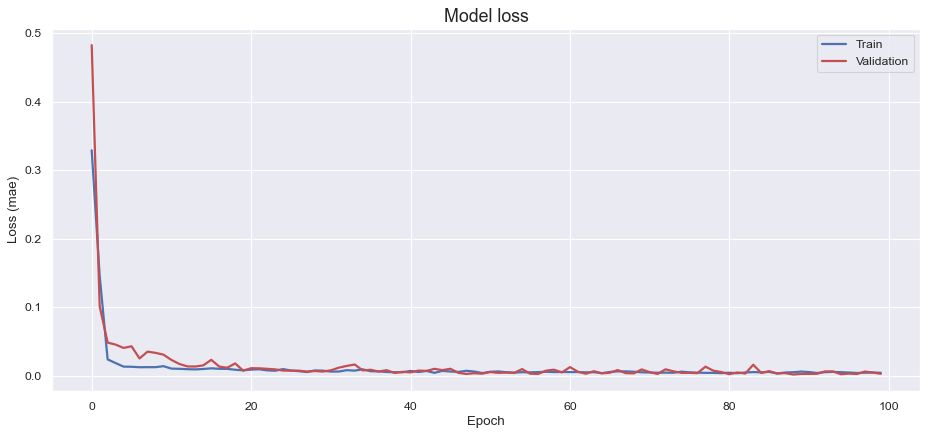

In [10]:
## Training accuracy 그리기
#fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
#ax.plot(history['acc'], 'b', label='Train', linewidth=2)
#ax.plot(history['val_acc'], 'r', label='Validation', linewidth=2)
#ax.set_title('Model accuracy', fontsize=16)
#ax.set_ylabel('Accuracy')
#ax.set_ylabel('Epoch')
#ax.legend(loc='upper right')
#plt.show()

## Training loss 그리기
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

C:\Users\HYS\anaconda3\envs\ratio2\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 0.03)

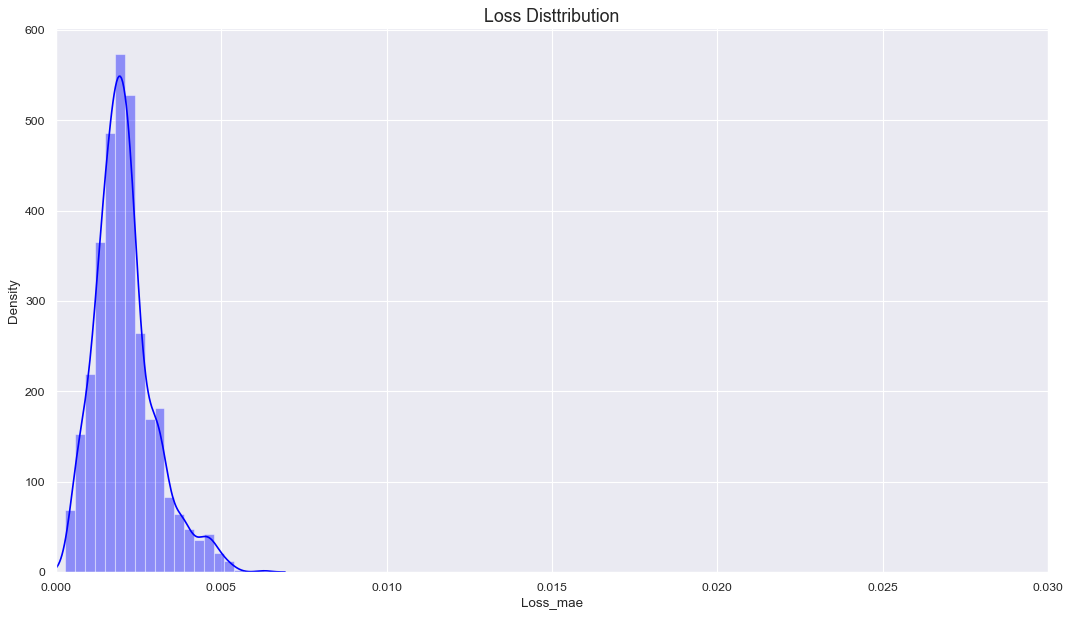

In [11]:
def restore(X, window_size):
    output_X = []
    for i in range(0, len(X)):
        output_X.append(X[i, 0])
        if (i == len(X) - 1):
            for j in range(1, window_size):
                output_X.append(X[i, j])
    return np.array(output_X)

# Training set의 loss 분포 그리기
X_pred = model.predict(X_train)
X_pred = restore(X_pred, window_size)
X_pred = pd.DataFrame(X_pred, columns=df.columns)
X_pred.index = df.index

scored = pd.DataFrame(index=df.index)
Xtrain = restore(X_train, window_size)
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis=1)
plt.figure(figsize=(16, 9), dpi=80)
plt.title('Loss Disttribution', fontsize=16)
sns.distplot(scored['Loss_mae'], bins=20, kde=True, color='blue')
plt.xlim([0.0, 0.03])

In [12]:
# test set에서 reconstruction loss 계산
print('anomaly threshold = {}'.format(np.percentile(scored, 100)))
threshold = np.percentile(scored, 100)

#X_pred = model.predict(X_test)
#X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
#X_pred = pd.DataFrame(X_pred, columns=test.columns)
#X_pred.index = test.index

#scored = pd.DataFrame(index=test.index)
#Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
#scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis=1)
#scored['Threshold'] = threshold
#scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
#scored[scored['Anomaly']==1]

anomaly threshold = 0.0062923063035214
